In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from IPython import get_ipython
from IPython.display import display

!pip install scikit-learn
!pip install typing-extensions

from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from typing import List, Dict, Union, Optional
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pandas as pd, numpy as np, re, nltk, csv, warnings, logging
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S')
logger = logging.getLogger(__name__)

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
nltk.download('punkt', quiet =True)
nltk.download('stopwords', quiet =True)

True

In [ ]:
class AdaptivePreprocessor(BaseEstimator, TransformerMixin):

    def __init__(self, text_max_features: int = 100, datetime_features: List[str] = None):
        self.text_max_features = text_max_features
        self.datetime_features = datetime_features or []
        self.preprocessor = None
        self.feature_names = None
        self._validate_input = True

    def fit(self, X: pd.DataFrame) -> 'AdaptivePreprocessor':
        X = X.copy()

        # Validate input
        if self._validate_input and not isinstance(X, pd.DataFrame):
            raise ValueError("Input must be a pandas DataFrame")

        # Initialize column types
        self.numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
        self.categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
        self.datetime_cols = []
        self.text_cols = []

        # Process datetime columns
        self._process_datetime_columns(X)

        # Process text columns
        self._process_text_columns(X)

        # Build preprocessing pipeline
        self._build_preprocessor()
        self.preprocessor.fit(X)

        # Get feature names
        self.feature_names = self._get_feature_names()

        return self

    def _process_datetime_columns(self, X: pd.DataFrame) -> None:
        for col in self.categorical_cols[:] + self.datetime_features:
            try:
                if col in X.columns:
                    X[col] = pd.to_datetime(X[col])
                    if col not in self.datetime_cols:
                        self.datetime_cols.append(col)
                    if col in self.categorical_cols:
                        self.categorical_cols.remove(col)
            except (ValueError, TypeError):
                if col in self.datetime_features:
                    logger.warning(f"Could not convert column '{col}' to datetime")

    def _process_text_columns(self, X: pd.DataFrame) -> None:
        for col in self.categorical_cols[:]:
            if X[col].apply(lambda x: isinstance(x, str)).any():
                avg_len = X[col].str.len().mean()
                if avg_len > 30:  # consider values with over 30 chars as text
                    self.text_cols.append(col)
                    self.categorical_cols.remove(col)

    def _build_preprocessor(self) -> None:
        transformers = []

        # Numeric pipeline
        if self.numeric_cols:
            numeric_pipeline = Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ])
            transformers.append(('num', numeric_pipeline, self.numeric_cols))

        # Categorical pipeline
        if self.categorical_cols:
            categorical_pipeline = Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ])
            transformers.append(('cat', categorical_pipeline, self.categorical_cols))

        # Text pipelines
        for col in self.text_cols:
            text_pipeline = Pipeline([
                ('vectorizer', TfidfVectorizer(
                    stop_words='english',
                    max_features=self.text_max_features
                ))
            ])
            transformers.append((f'text_{col}', text_pipeline, col))

        self.preprocessor = ColumnTransformer(
            transformers=transformers,
            remainder='drop',
            verbose_feature_names_out=False
        )

    def transform(self, X: pd.DataFrame) -> np.ndarray:
        if self.preprocessor is None:
            raise RuntimeError("Preprocessor not fitted yet")
        return self.preprocessor.transform(X)

    def transform_to_dataframe(self, X: pd.DataFrame) -> pd.DataFrame:
        transformed = self.transform(X)
        return pd.DataFrame(transformed, columns=self.feature_names)

    def _get_feature_names(self) -> List[str]:
        names = []
        for name, transformer, columns in self.preprocessor.transformers_:
            if hasattr(transformer, 'get_feature_names_out'):
                if isinstance(columns, str): columns = [columns]
                names.extend(transformer.get_feature_names_out(columns))
            else:
                if isinstance(columns, list): names.extend(columns)
                else: names.append(columns)
        return names

    def get_feature_names(self) -> List[str]:
        return self.feature_names

    def get_schema(self) -> Dict[str, str]:
        return {name: "float" for name in self.feature_names}

In [ ]:
class ModelTrainer:
    def __init__(self, test_size: float = 0.2, random_state: int = 42):
        self.test_size = test_size
        self.random_state = random_state
        self.models = {
            "Logistic Regression": LogisticRegression(max_iter=1000),
            "Random Forest": RandomForestClassifier(),
            "Neural Network": MLPClassifier(max_iter=300)
        }
        self.best_model = None
        self.best_score = 0

    def train_models(self, X: np.ndarray, y: np.ndarray) -> Dict[str, object]:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size=self.test_size,
            random_state=self.random_state
        )

        trained_models = {}
        for name, model in self.models.items():
            logger.info(f"Training {name}...")
            model.fit(X_train, y_train)
            trained_models[name] = model

            # Evaluate and track best model
            score = model.score(X_test, y_test)
            logger.info(f"{name} test accuracy: {score:.4f}")

            if score > self.best_score:
                self.best_score = score
                self.best_model = name

        logger.info(f"\nBest model: {self.best_model} with accuracy {self.best_score:.4f}")
        return trained_models, X_test, y_test

    def evaluate_models(self, models: Dict[str, object], X_test: np.ndarray, y_test: np.ndarray) -> None:
        for name, model in models.items():
            y_pred = model.predict(X_test)
            print(f"\n{name} Evaluation:")
            print(classification_report(y_test, y_pred))
            print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

            # Add confusion matrix visualization
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
            plt.title(f"{name} Confusion Matrix")
            plt.xlabel("Predicted Label")
            plt.ylabel("True Label")
            plt.show()



Logistic Regression Evaluation:
              precision    recall  f1-score   support

         <30       0.36      0.03      0.06      2285
         >30       0.50      0.38      0.44      7117
          NO       0.61      0.83      0.70     10952

    accuracy                           0.58     20354
   macro avg       0.49      0.41      0.40     20354
weighted avg       0.55      0.58      0.54     20354

Accuracy: 0.5824


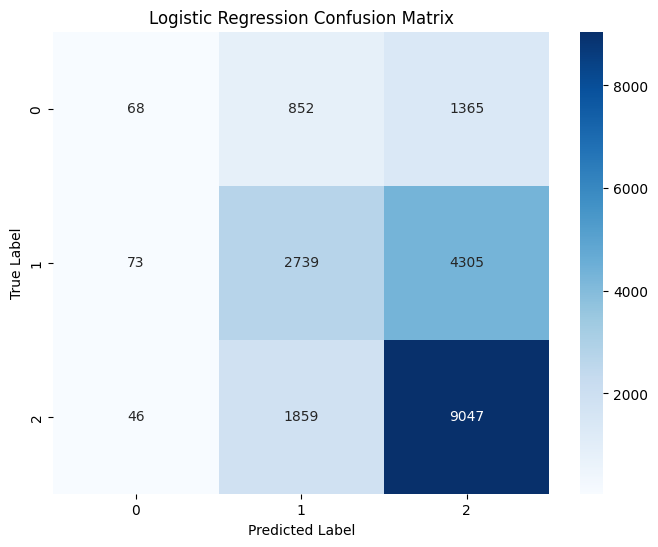


Random Forest Evaluation:
              precision    recall  f1-score   support

         <30       0.45      0.01      0.02      2285
         >30       0.53      0.38      0.44      7117
          NO       0.62      0.86      0.72     10952

    accuracy                           0.60     20354
   macro avg       0.53      0.42      0.39     20354
weighted avg       0.57      0.60      0.54     20354

Accuracy: 0.5964


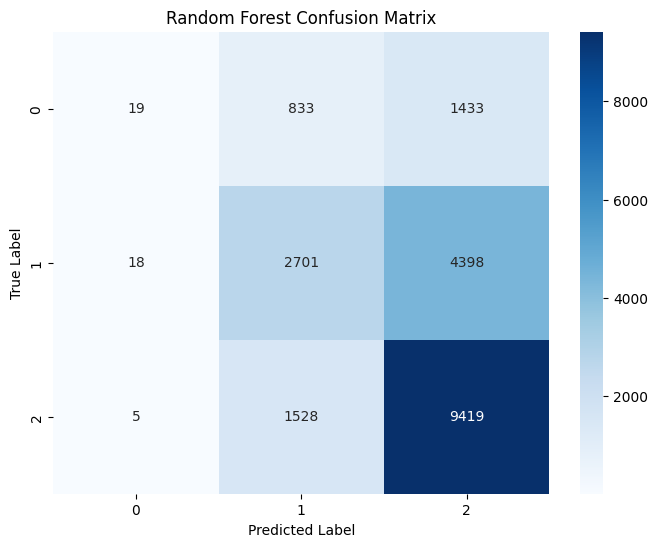


Neural Network Evaluation:
              precision    recall  f1-score   support

         <30       0.16      0.16      0.16      2285
         >30       0.42      0.39      0.41      7117
          NO       0.61      0.63      0.62     10952

    accuracy                           0.49     20354
   macro avg       0.39      0.39      0.39     20354
weighted avg       0.49      0.49      0.49     20354

Accuracy: 0.4936


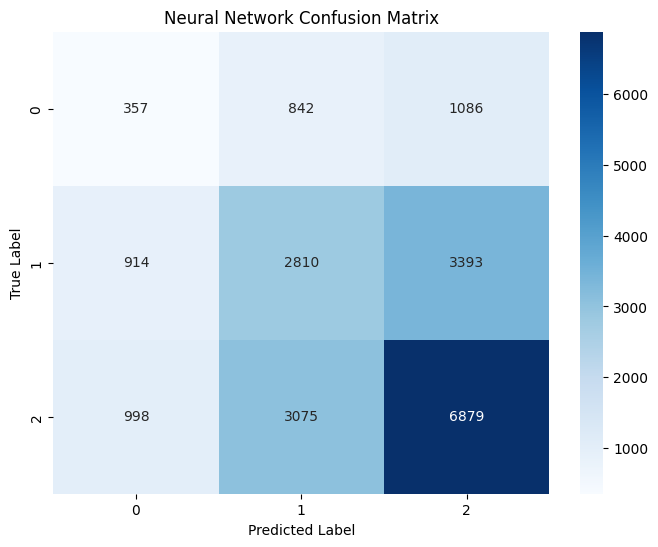

In [ ]:
def main(target_col: str, data:pd.DataFrame):
    try:
        X = data.drop(target_col, axis=1)
        y = data[target_col]

        # 2. Preprocess data
        preprocessor = AdaptivePreprocessor(text_max_features=100)
        preprocessor.fit(X)
        X_processed = preprocessor.transform(X)

        # 3. Train models
        trainer = ModelTrainer()
        models, X_test, y_test = trainer.train_models(X_processed, y)

        # 4. Evaluate models
        trainer.evaluate_models(models, X_test, y_test)

    except Exception as e:
        logger.error(f"Error in pipeline: {str(e)}")
        raise

if __name__ == "__main__":
    target_col ='readmitted'
    data_file_path = '/content/drive/MyDrive/diabetic_data.csv'
    df = pd.read_csv(data_file_path)
    main(target_col, data=df)

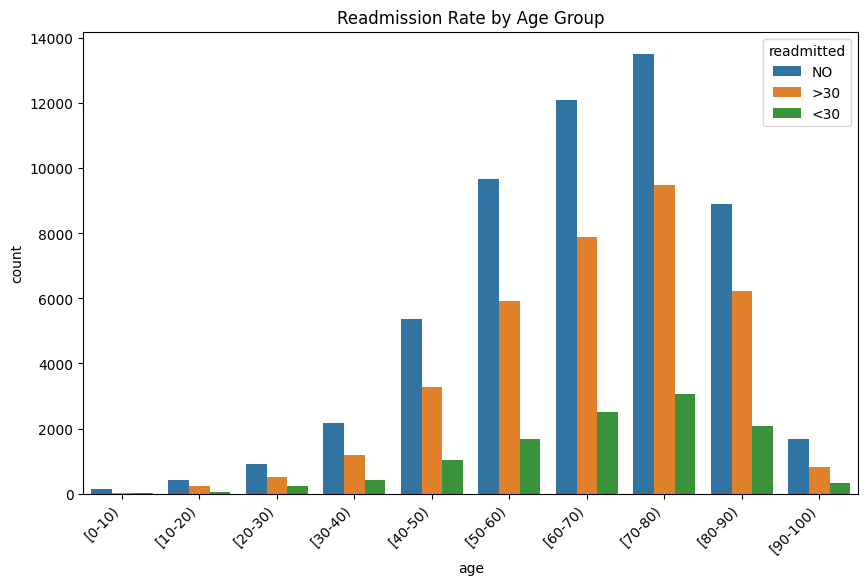

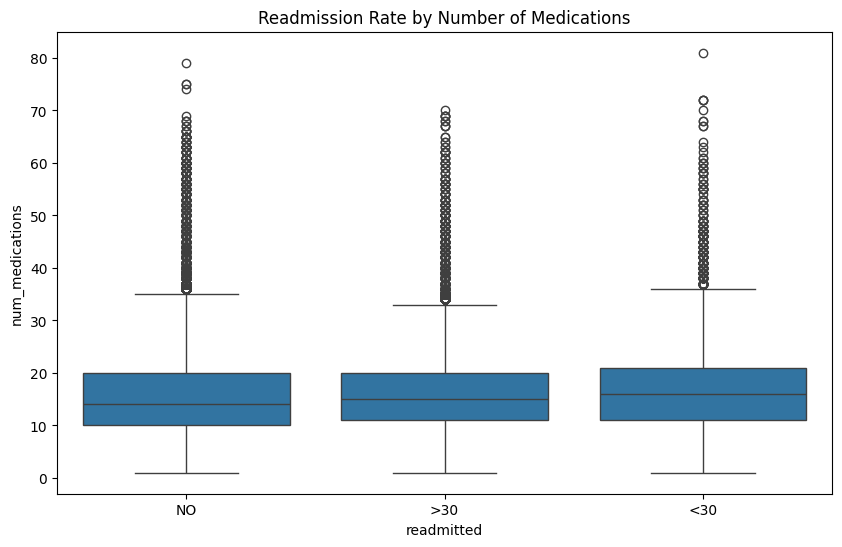

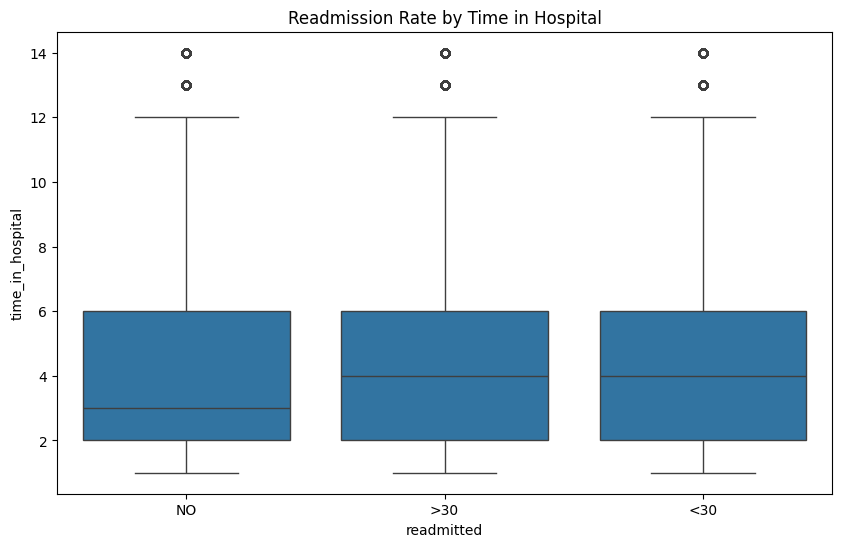

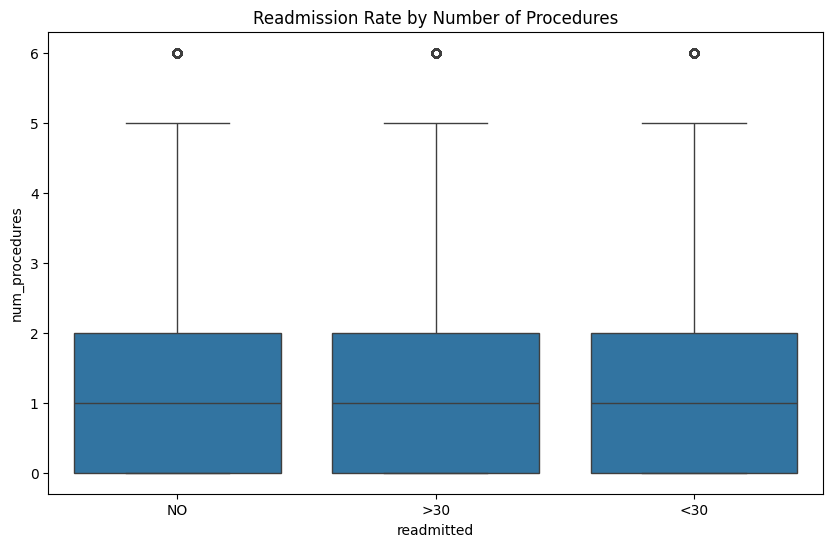

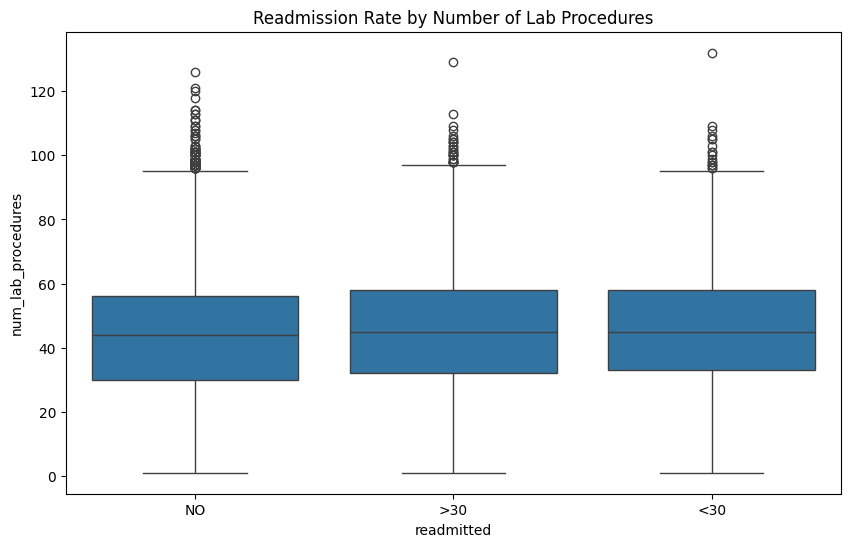

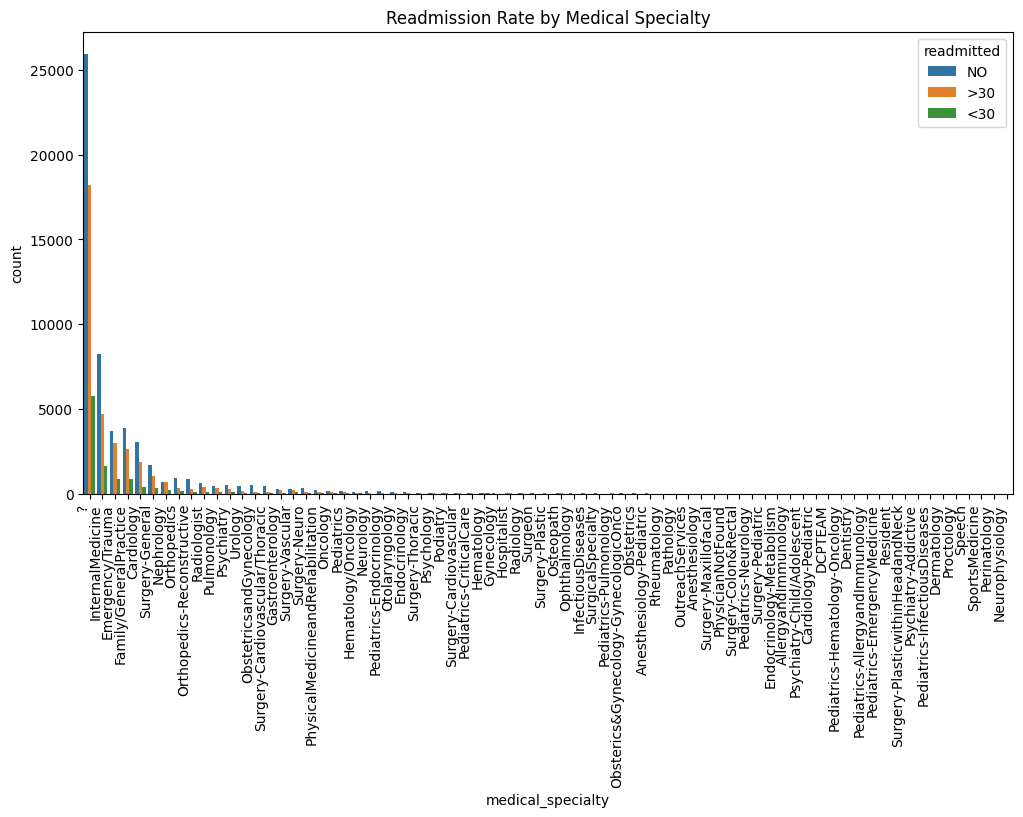

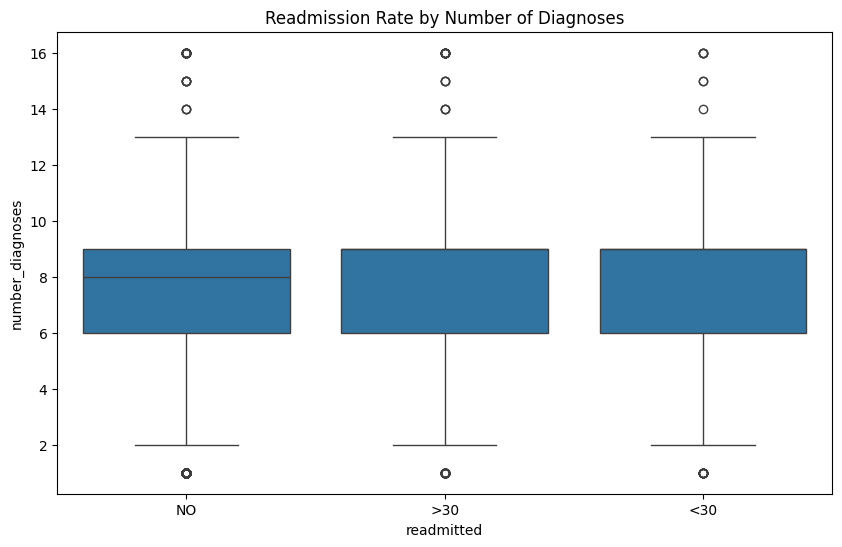

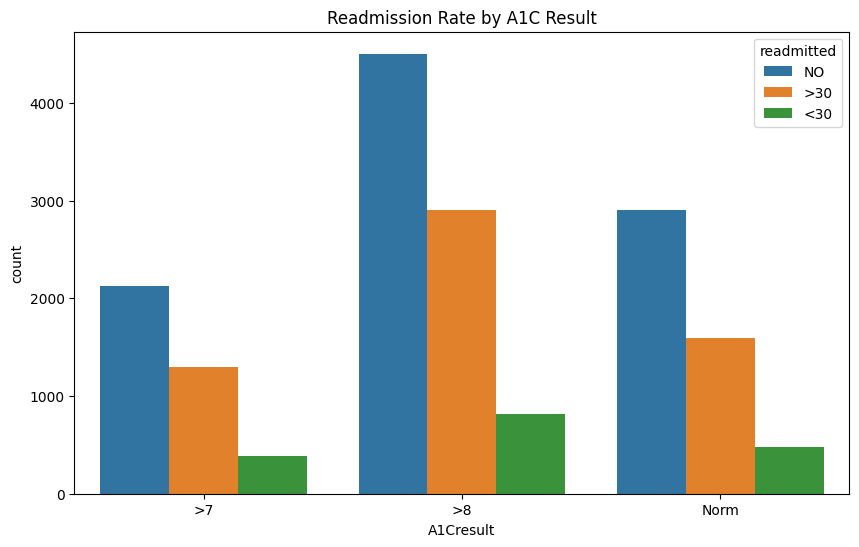

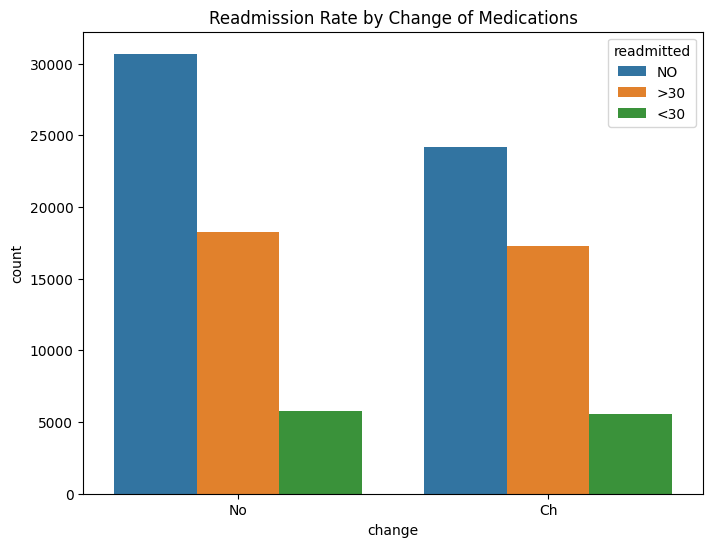

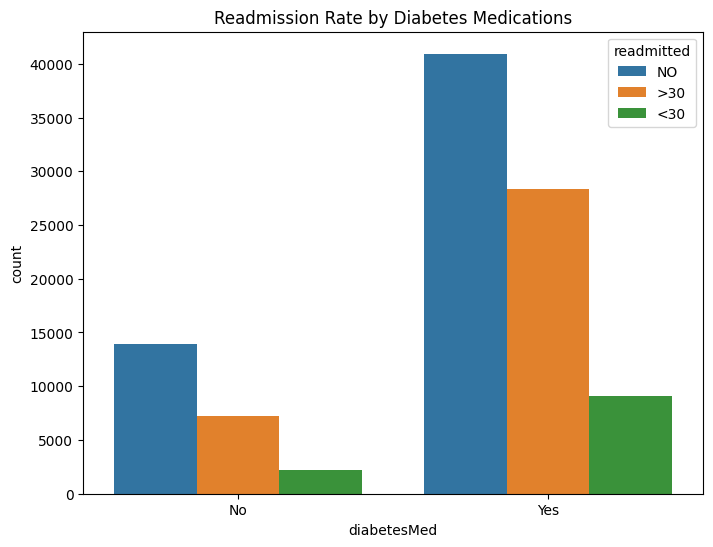

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Readmission Rate by Age Group
plt.figure(figsize=(10, 6))
sns.countplot(x='age', data=df, hue='readmitted')
plt.title('Readmission Rate by Age Group')
plt.xticks(rotation=45, ha='right')
plt.show()

# 2. Readmission Rate by Number of Medications
plt.figure(figsize=(10, 6))
sns.boxplot(x='readmitted', y='num_medications', data=df)
plt.title('Readmission Rate by Number of Medications')
plt.show()

# 3. Readmission Rate by Time in Hospital
plt.figure(figsize=(10, 6))
sns.boxplot(x='readmitted', y='time_in_hospital', data=df)
plt.title('Readmission Rate by Time in Hospital')
plt.show()

# 4. Readmission Rate by Number of Procedures
plt.figure(figsize=(10, 6))
sns.boxplot(x='readmitted', y='num_procedures', data=df)
plt.title('Readmission Rate by Number of Procedures')
plt.show()

# 5. Readmission Rate by Number of Lab Procedures
plt.figure(figsize=(10, 6))
sns.boxplot(x='readmitted', y='num_lab_procedures', data=df)
plt.title('Readmission Rate by Number of Lab Procedures')
plt.show()

# 6. Readmission Rate by Medical Specialty
plt.figure(figsize=(12, 6))
sns.countplot(x='medical_specialty', data=df, hue='readmitted', order=df['medical_specialty'].value_counts().index)
plt.title('Readmission Rate by Medical Specialty')
plt.xticks(rotation=90, ha='right')
plt.show()

# 7. Readmission Rate by Number of Diagnoses
plt.figure(figsize=(10, 6))
sns.boxplot(x='readmitted', y='number_diagnoses', data=df)
plt.title('Readmission Rate by Number of Diagnoses')
plt.show()

# 8. Readmission Rate by A1C Result
plt.figure(figsize=(10, 6))
sns.countplot(x='A1Cresult', data=df, hue='readmitted')
plt.title('Readmission Rate by A1C Result')
plt.show()

# 9. Readmission Rate by Change of Medications
plt.figure(figsize=(8, 6))
sns.countplot(x='change', data=df, hue='readmitted')
plt.title('Readmission Rate by Change of Medications')
plt.show()

# 10. Readmission Rate by Diabetes Medications
plt.figure(figsize=(8, 6))
sns.countplot(x='diabetesMed', data=df, hue='readmitted')
plt.title('Readmission Rate by Diabetes Medications')
plt.show()

In [ ]:
# Get the number of columns
num_attributes = df.shape[1]